# LSTMs for Raw Signal Processing

## Loading The Data

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
wisdm_path = '/scratch/network/jr8867/wisdm-dataset'
segmented_signal_path = f'{wisdm_path}/segmented'
X = np.load(os.path.join(segmented_signal_path, 'X_segments.npy'))
y = np.load(os.path.join(segmented_signal_path, 'y_segments.npy'))

In [7]:
# Map labels to numbers
label_mapping = {'A': 0, 'B': 1, 'D': 2, 'E': 3}
y = np.vectorize(label_mapping.get)(y)

In [8]:
print("Training Instance Features: ", X.shape)
print("Training Instance Labels", y.shape)

Training Instance Features:  (2939, 201, 6)
Training Instance Labels (2939,)


In [9]:
# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# LSTM

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Create a custom dataset
class SensorDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences.astype('float32')
        self.labels = labels.astype('int64')
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence), torch.tensor(label)

In [12]:
# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        # Using nn.LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Initialize loss function and optimizer as instance variables
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        # out shape: (batch, seq_length, hidden_size)
        out, (hidden_n, cell_n) = self.lstm(x)
        # We'll use the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def train_model(self, train_loader, num_epochs=10):
        self.train()
        progress_bar = tqdm(range(num_epochs))
        for epoch in progress_bar:
            epoch_losses = []
            for sequences, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self(sequences)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())
            
            avg_loss = sum(epoch_losses) / len(epoch_losses)
            progress_bar.set_description(f"Loss: {avg_loss:.4f} |")

In [13]:
# Create DataLoaders for train and test sets
batch_size = 32
train_dataset = SensorDataset(X_train, y_train)
valid_dataset = SensorDataset(X_valid, y_valid)
test_dataset = SensorDataset(X_test, y_test)
comb_dataset = train_dataset + valid_dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
comb_loader = DataLoader(comb_dataset, batch_size=batch_size, shuffle=True)

In [14]:
# Define model constants
input_size = X_train.shape[2]   # number of features
num_classes = len(set(y_train))  # adjust based on your unique labels

In [15]:
param_grid = {
    'hidden_size': [16, 32, 64],
    'num_layers': [1, 2, 3]
}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    # Instantiate the model
    model = LSTMModel(input_size, hidden_size=params['hidden_size'], num_layers=params['num_layers'], num_classes=num_classes)

    # Training the model
    model.train_model(train_loader, num_epochs=25)

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in valid_loader:
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy for hidden_size={params['hidden_size']}, num_layers={params['num_layers']}: {accuracy:.4f}")

    # Save the best parameters based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy:.4f} with parameters: {best_params}")

Loss: 0.1883 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.08it/s]


Test Accuracy for hidden_size=16, num_layers=1: 0.9177


Loss: 0.2514 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.66it/s]


Test Accuracy for hidden_size=16, num_layers=2: 0.9262


Loss: 0.5015 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.77it/s]


Test Accuracy for hidden_size=16, num_layers=3: 0.7305


Loss: 0.1818 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.94it/s]


Test Accuracy for hidden_size=32, num_layers=1: 0.9418


Loss: 0.1465 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.34it/s]


Test Accuracy for hidden_size=32, num_layers=2: 0.9433


Loss: 0.3927 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.11s/it]


Test Accuracy for hidden_size=32, num_layers=3: 0.8199


Loss: 0.1192 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.24it/s]


Test Accuracy for hidden_size=64, num_layers=1: 0.9362


Loss: 0.1167 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:55<00:00,  2.23s/it]


Test Accuracy for hidden_size=64, num_layers=2: 0.9305


Loss: 0.1745 |: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:16<00:00,  3.07s/it]


Test Accuracy for hidden_size=64, num_layers=3: 0.9404
Best Accuracy: 0.9433 with parameters: {'hidden_size': 32, 'num_layers': 2}


In [19]:
# Instantiate the model
model = LSTMModel(input_size, hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers'], num_classes=num_classes)

# Training the model
model.train_model(comb_loader, num_epochs=300)

  0%|                                                                                                                                                                                                       | 0/300 [00:00<?, ?it/s]

Loss: 0.0307 |: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [04:52<00:00,  1.03it/s]


Test Accuracy: 0.9469


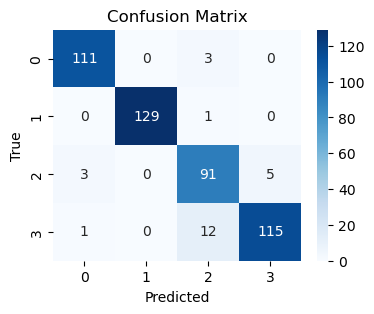

,Class,Accuracy,F1 Score,Precision,Recall
0,0,0.973684,0.969432,0.965217,0.973684
1,1,0.992308,0.996139,1.000000,0.992308
2,2,0.919192,0.883495,0.850467,0.919192
3,3,0.898438,0.927419,0.958333,0.898438


In [20]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for sequences, labels in test_loader:
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(all_labels), 
            yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Calculate precision and recall
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
# Calculate F1 scores
f1_scores = f1_score(all_labels, all_preds, average=None)

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Class': range(len(class_accuracy)),
    'Accuracy': class_accuracy,
    'F1 Score': f1_scores,
    'Precision': precision,
    'Recall': recall
})
metrics_df

LSTMs have a bit more of a leg up against RNNs. This is perhaps due to the ability to remember long term information (such as min and max values - could help with variance estimation.)